In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

/Users/malenamalka/opt/anaconda3/lib/python3.9/site-packages/requests/__init__.py:113: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (2.0.3)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
#Week 1 work
start_date = '2010-01-01'
end_date = '2019-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)
sp500_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-01,1073.869995,1150.449951,1071.589966,1116.560059,90947580000
2010-02-01,1104.489990,1112.420044,1044.500000,1073.890015,84561340000
2010-03-01,1169.430054,1180.689941,1105.359985,1105.359985,103683550000
2010-04-01,1186.689941,1219.800049,1170.689941,1171.229980,116741910000
2010-05-01,1089.410034,1205.130005,1040.780029,1188.579956,127662780000


In [22]:
sp500_data = sp500_data[['Close']].dropna()

sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

sp500_data.dropna(inplace=True)

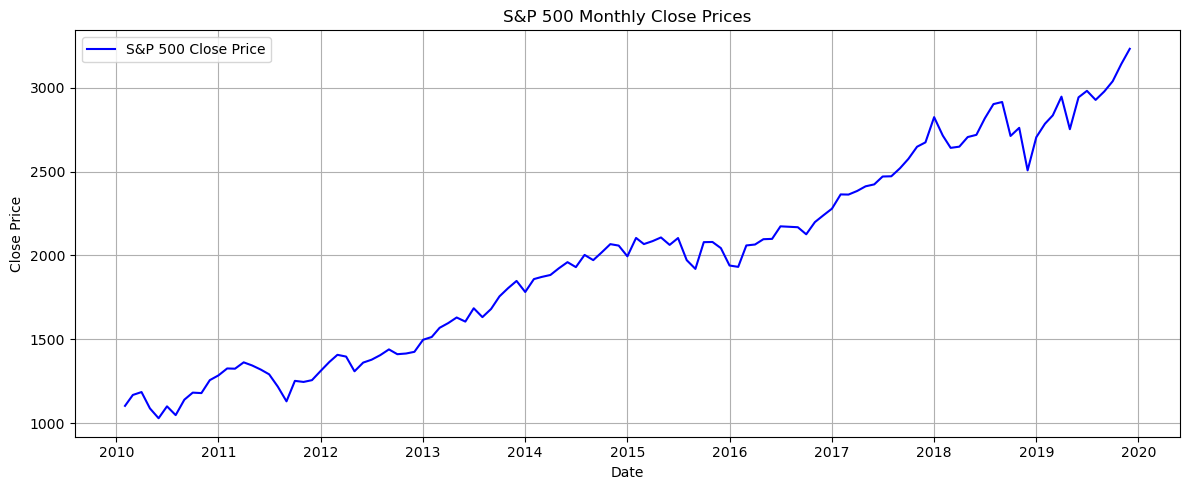

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

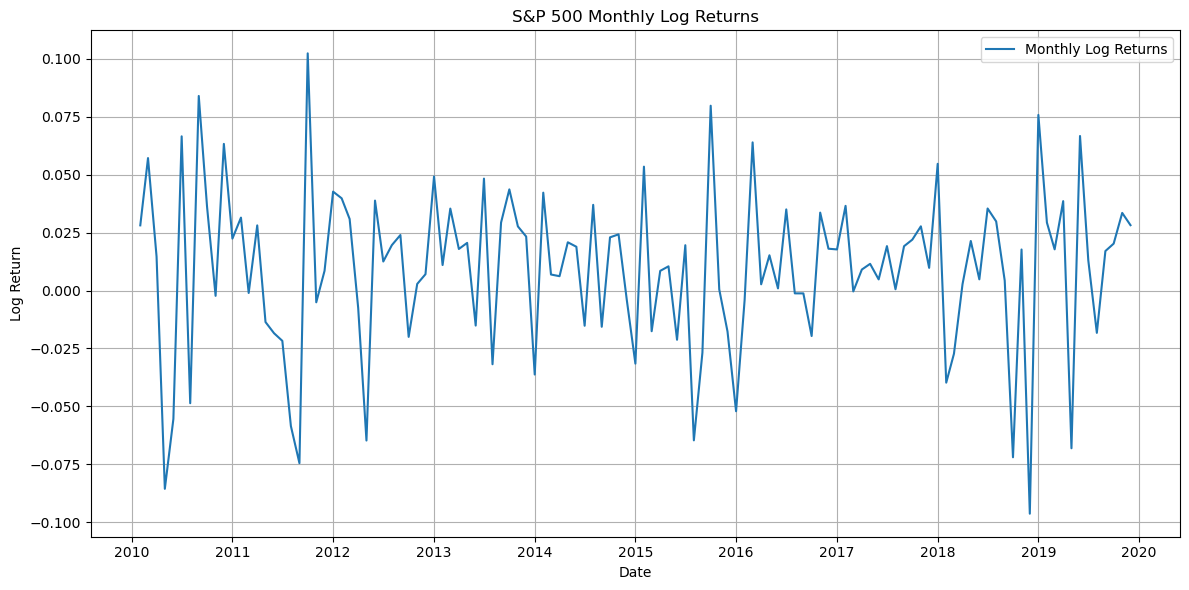

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

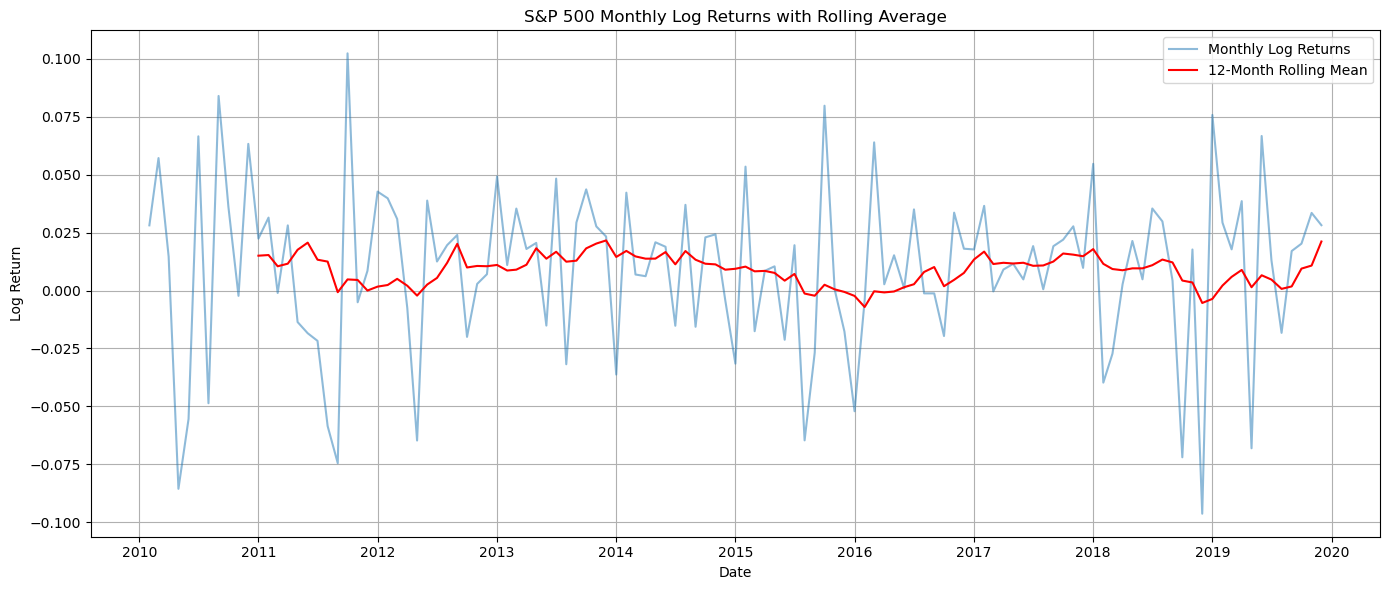

In [25]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

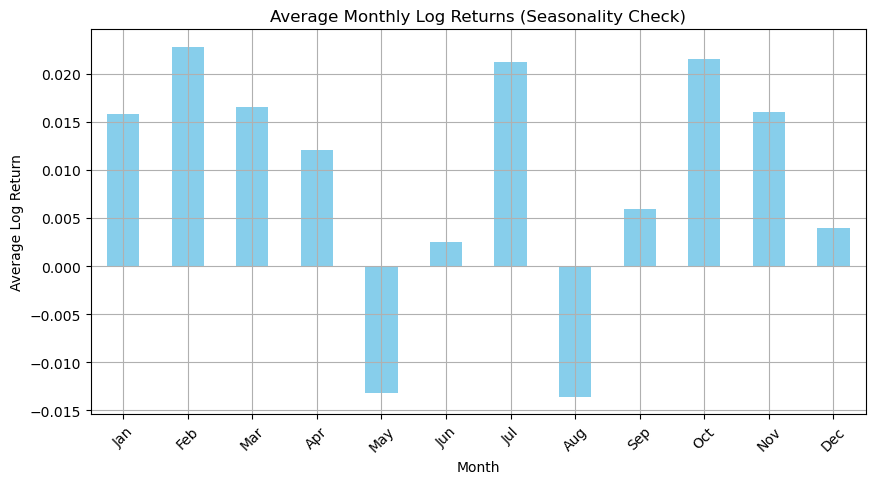

In [26]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

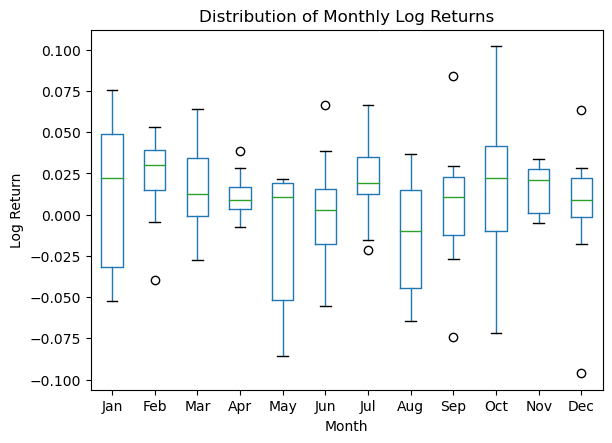

In [27]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [29]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -12.631859
p-value: 0.000000
Critical Values:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


**Analysis:**

The ADF test statistic of -12.632 and the p-value of 0.000000 both indicate that the null hypothesis of a unit root can be rejected with strong confidence. This supports the conclusion that the log return time series is stationary, meaning it does not exhibit a persistent trend or non-stationary behavior. Since the test statistic is more negative than the 1% critical value (-3.487), we can reject the null hypothesis even at the strictest level of significance. This confirms that modeling the log returns without differencing is appropriate and aligns with the typical properties of financial return series.

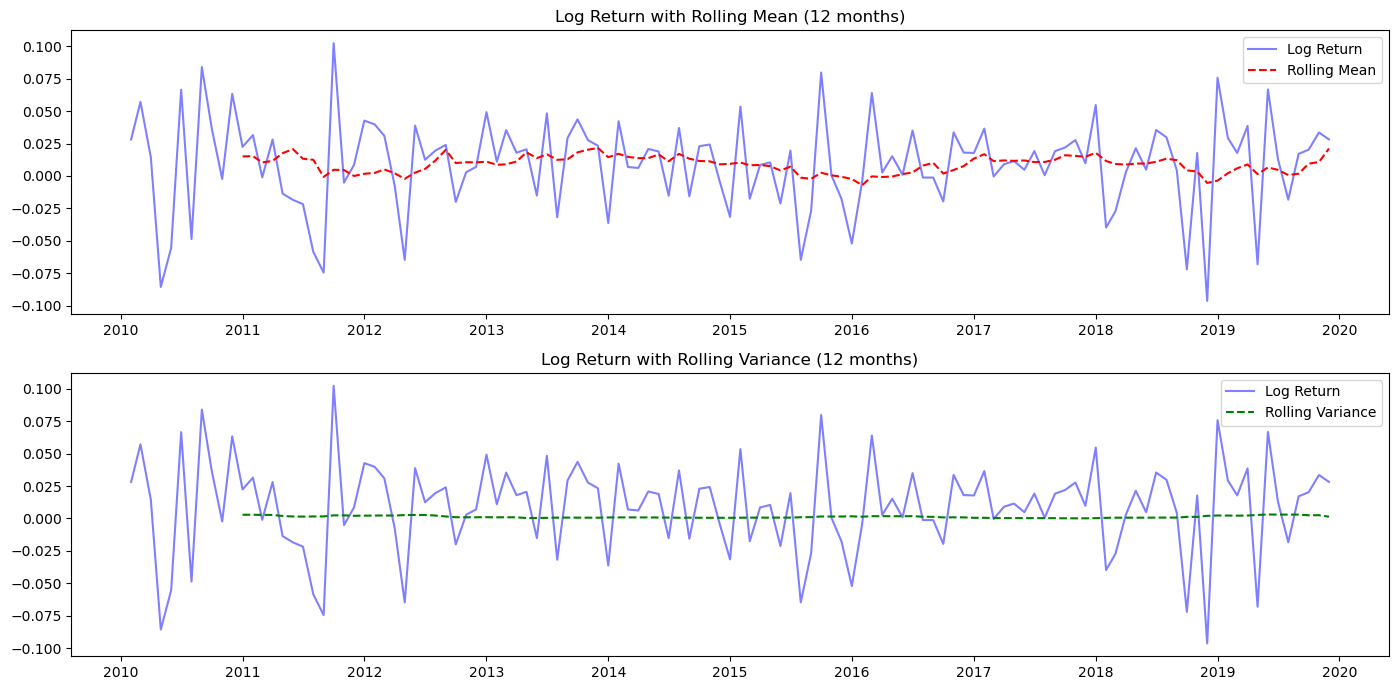

In [31]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

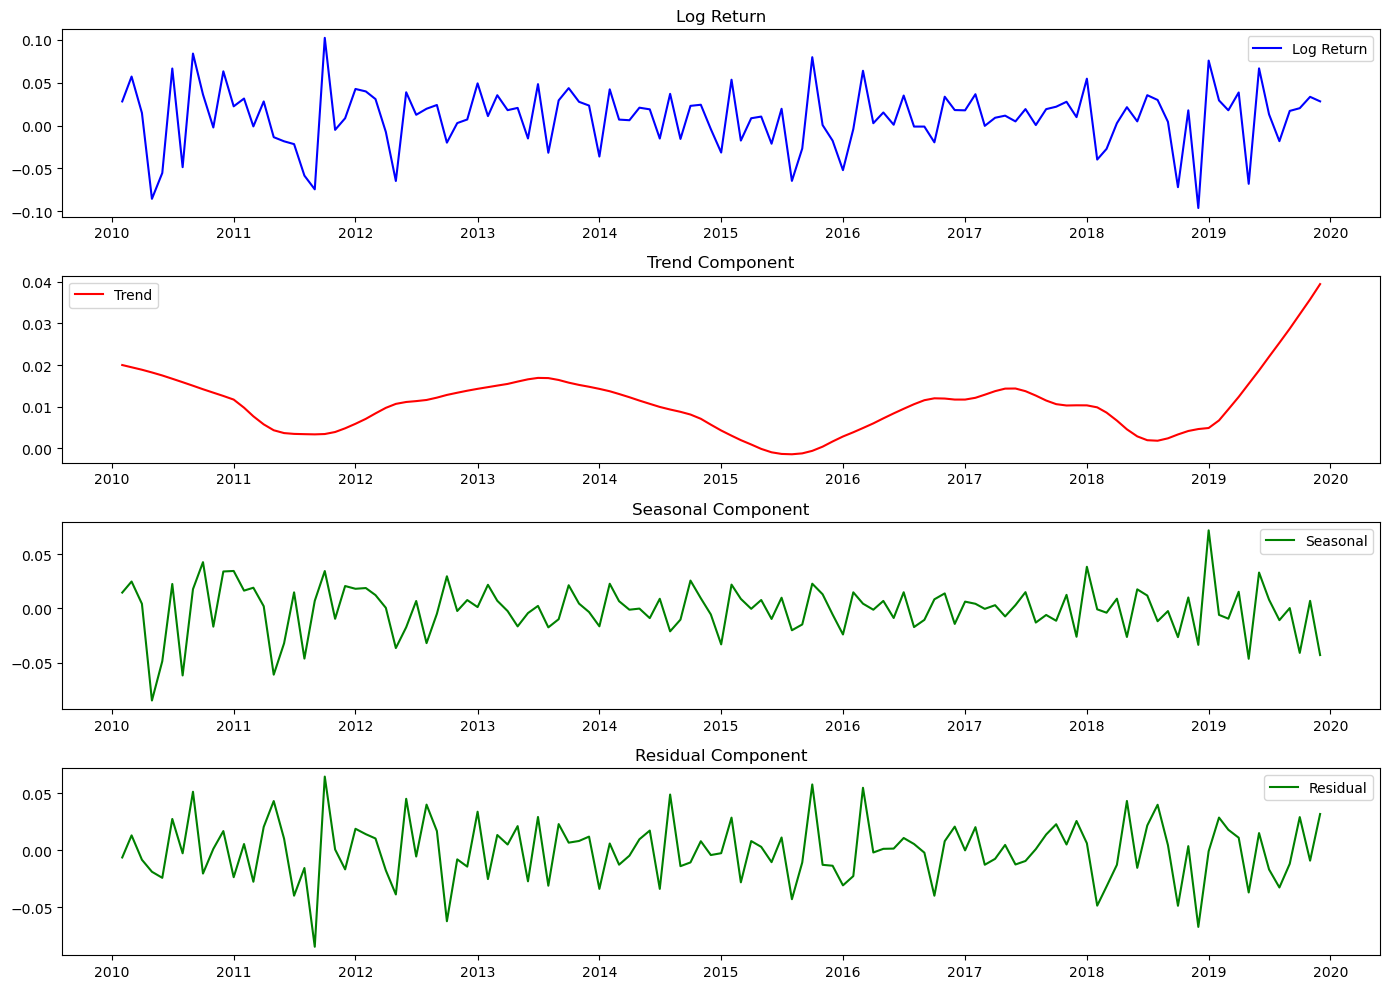

In [32]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 232.795
Date:                Mon, 28 Apr 2025   AIC                           -457.590
Time:                        10:17:04   BIC                           -446.473
Sample:                    02-01-2010   HQIC                          -453.076
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0089      0.001     15.152      0.000       0.008       0.010
ar.L1          0.8073      0.066     12.218      0.000       0.678       0.937
ma.L1         -0.9988      0.65

**Analysis:**

The ARIMA(1, 0, 1) model results show the following:

Constant (const): The coefficient is 0.0089 and is statistically significant (p-value = 0.000), suggesting that the average monthly log return during this period is positive and meaningfully different from zero.

AR(1) coefficient: The coefficient is 0.8073 and is highly statistically significant (p-value = 0.000), indicating that the previous month's return has a strong and positive influence on the current return.

MA(1) coefficient: The coefficient is -0.9988 with a p-value of 0.125, meaning it is not statistically significant. This suggests that the first moving average term does not capture significant short-term error corrections.

Sigma2: The residual variance (σ²) is 0.0011, but with a p-value of 0.101, meaning it is not statistically significant at conventional levels. However, the variance estimate remains small and reasonable for financial returns.

Ljung-Box (Q) test: The p-value of 0.51 indicates no significant autocorrelation remains in the residuals at lag 1, suggesting that the model adequately captures the major dynamics in the data.

Jarque-Bera (JB) test: The p-value of 0.00 shows that the residuals are not normally distributed, with noticeable left skewness (-0.84) and slight excess kurtosis (3.87), both of which are typical features in financial returns.

Heteroskedasticity (H): The p-value of 0.18 suggests that there is no strong evidence of heteroskedasticity in the residuals, meaning the volatility appears stable over time.



In [34]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88553D+00    |proj g|=  1.22364D+00

At iterate    5    f= -1.88605D+00    |proj g|=  2.79343D-01

At iterate   10    f= -1.88622D+00    |proj g|=  1.62504D-03

At iterate   15    f= -1.88623D+00    |proj g|=  2.25942D-03

At iterate   20    f= -1.88637D+00    |proj g|=  3.73428D-01

At iterate   25    f= -1.89088D+00    |proj g|=  2.57815D-01

At iterate   30    f= -1.89165D+00    |proj g|=  1.51627D-01

At iterate   35    f= -1.89197D+00    |proj g|=  2.55112D-02


 This problem is unconstrained.



At iterate   40    f= -1.89197D+00    |proj g|=  4.42364D-03

At iterate   45    f= -1.89205D+00    |proj g|=  7.35327D-02

At iterate   50    f= -1.89207D+00    |proj g|=  6.43762D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   6.438D-04  -1.892D+00
  F =  -1.8920716434624014     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                         Log Return   No. Observations:                  119
Model:             SARIMAX(1, 0,

**Analysis:**


The SARIMA(1, 0, 1)(1, 0, 1, 12) model results show the following:

AR(1) coefficient: The coefficient is -0.2591 with a p-value of 0.771, meaning it is not statistically significant. This suggests that the first lag of the series does not strongly influence the current log return.

MA(1) coefficient: The coefficient is 0.1680 with a p-value of 0.853, meaning it is not statistically significant. This indicates that past errors do not meaningfully contribute to explaining current returns in this model.

Seasonal AR(12) coefficient: The coefficient is -0.8251 with a p-value of 0.093, making it marginally not significant at the 5% level but close to potential significance. This hints at some seasonal autoregressive effect but not strong enough to be conclusive.

Seasonal MA(12) coefficient: The coefficient is 0.7502 with a p-value of 0.182, meaning it is not statistically significant, and there is no clear seasonal moving average pattern.

Sigma2: The error variance (σ²) is 0.0013 and is highly significant (p-value = 0.000), confirming that the model reliably estimates residual variability.

Ljung-Box (Q) test: The p-value of 0.38 suggests no significant autocorrelation remains in the residuals, meaning the model captures the main time-dependent structure effectively.

Jarque-Bera (JB) test: The p-value of 0.01 indicates that the residuals are not normally distributed, with moderate left skewness (-0.59) and slight excess kurtosis (3.60), typical in financial time series.

Heteroskedasticity (H): The p-value of 0.16 suggests that there is no strong evidence of heteroskedasticity (changing variance) in the residuals.

Comparison to ARIMA:
Comparing the two models, the ARIMA(1,0,1) clearly outperforms the SARIMA(1,0,1)(1,0,1,12) model for this period. The ARIMA model has a lower AIC (-457.590 vs. -440.313) and a higher log-likelihood (232.795 vs. 225.157), indicating a better overall fit. Furthermore, the SARIMA model's seasonal terms are not statistically significant, suggesting that adding seasonal structure does not meaningfully improve forecasting or explanation. Therefore, the simpler ARIMA(1,0,1) model is preferred for modeling log returns between 2010 and 2019.



In [35]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     1.261
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.257
Time:                        10:27:09   Log-Likelihood:                 235.11
No. Observations:                 119   AIC:                            -446.2
Df Residuals:                     107   BIC:                            -412.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

Analysis:
The OLS regression results for monthly dummies show the following key findings:

Intercept (const): The coefficient is 0.0158 with a p-value of 0.182, meaning it is not statistically significant. This suggests that the average log return for the baseline month (January) is not meaningfully different from zero.

Other Months: None of the monthly dummy coefficients (February through December) are statistically significant at conventional levels (all p-values > 0.05). This indicates that there are no strong or consistent seasonal patterns in returns across different months during this sample period.

Model Fit: The R-squared value is 0.115, meaning the model explains about 11.5% of the variation in log returns. However, the overall F-statistic p-value (0.257) suggests the model is not statistically significant as a whole.

Jarque-Bera test: The p-value is 0.0902, suggesting that the residuals are approximately normally distributed, as the p-value is greater than 0.05.

Skew: The skewness value is -0.427, indicating that the residuals are moderately left-skewed.

Kurtosis: The kurtosis is 3.491, which is slightly higher than 3, suggesting that the residuals have somewhat heavier tails than a perfect normal distribution, a common feature in financial data.

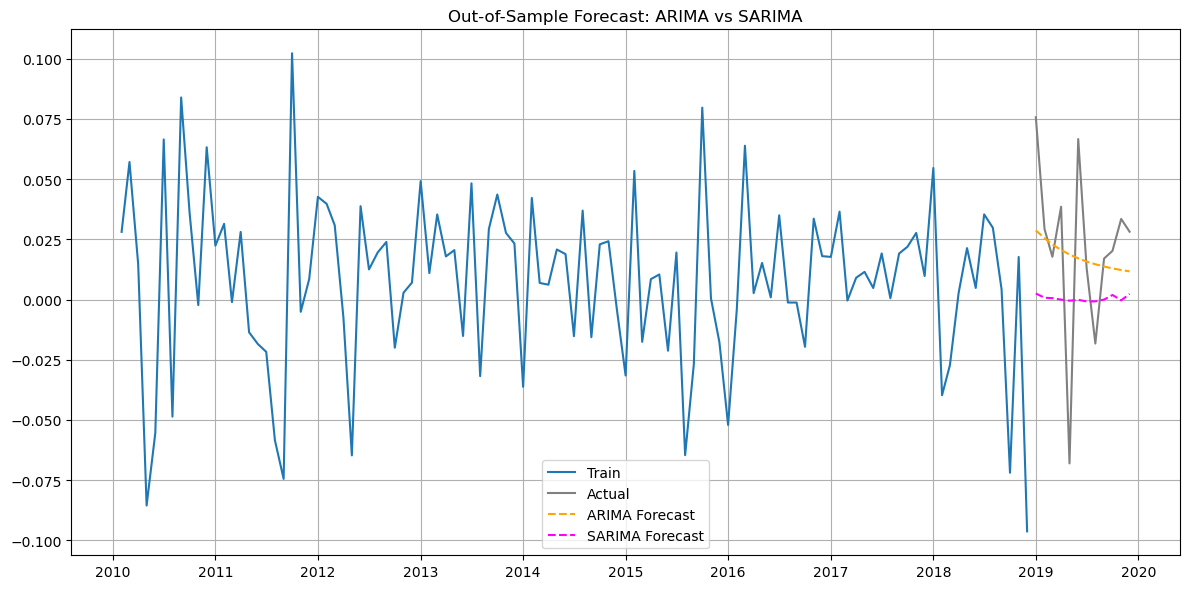

In [36]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

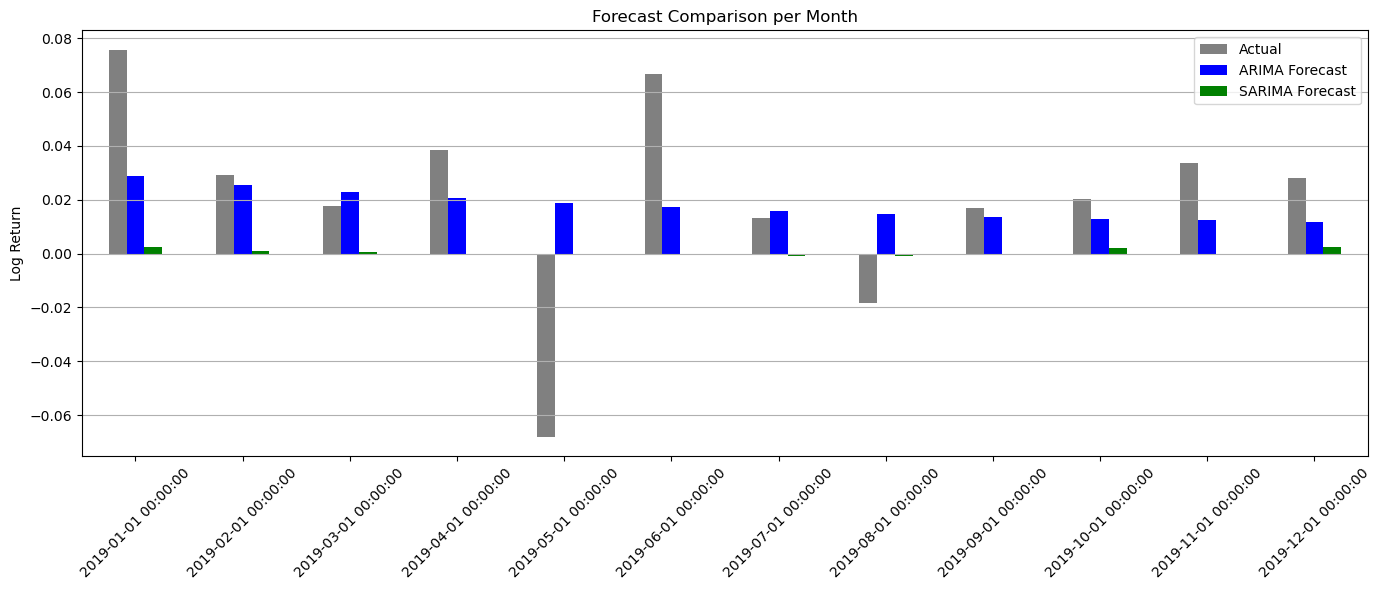

In [37]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

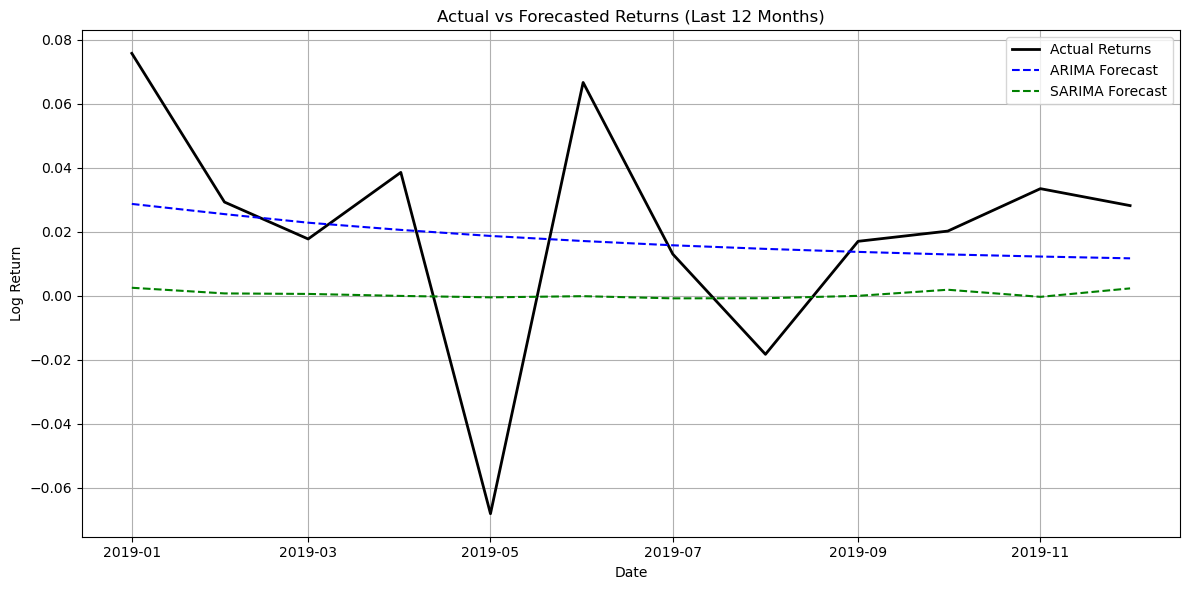

In [38]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.02451
ARIMA RMSE: 0.03468

SARIMA MAE: 0.03485
SARIMA RMSE: 0.04074


**Analysis:**


ARIMA outperforms SARIMA in forecast accuracy, with a lower MAE (0.02451) and RMSE (0.03468) compared to SARIMA's MAE (0.03485) and RMSE (0.04074). However, both models show relatively low levels of forecasting error overall, suggesting that either model performs reasonably well, but ARIMA provides slightly more accurate predictions in the last 12 months.



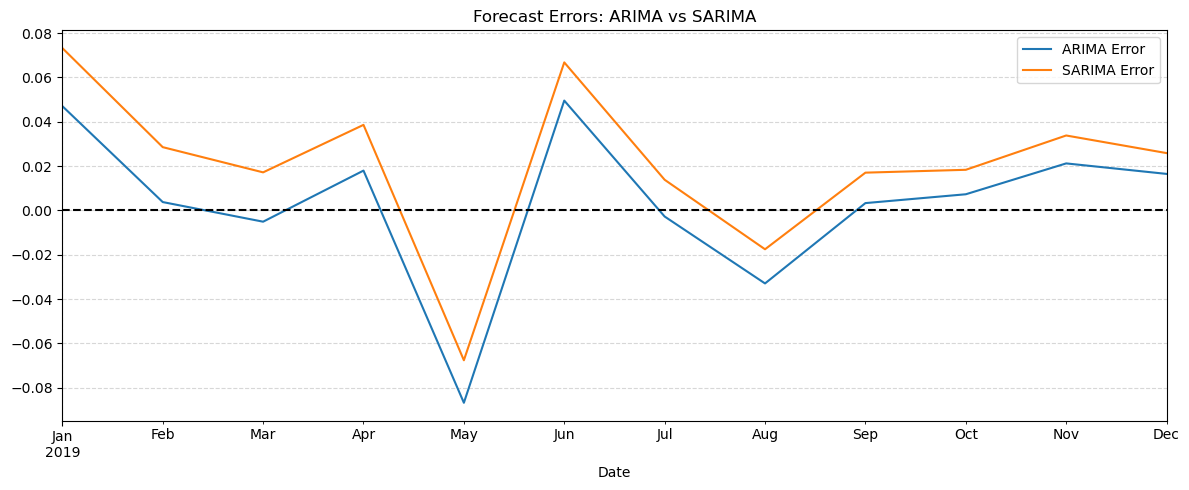

In [40]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()